In [49]:
pip install transformers datasets scikit-learn pandas torch

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

In [51]:
# Load your dataset (ensure it has 'text' and 'label' columns)
df = pd.read_csv("/content/Toddler Autism dataset July 2018.csv")  # Your CSV with ASD screening responses

In [52]:
!ls -l /content/Toddler\ Autism\ dataset\ July\ 2018.csv

-rw-r--r-- 1 root root 71199 Apr  6 06:11 '/content/Toddler Autism dataset July 2018.csv'


In [53]:
!chmod a+r /content/Toddler\ Autism\ dataset\ July\ 2018.csv

In [54]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Confirm label column exists
if 'Class/ASD Traits' in df.columns:
    df['label'] = df['Class/ASD Traits'].str.strip().str.lower().map({'yes': 1, 'no': 0})
else:
    raise ValueError("Column 'Class/ASD Traits' not found in DataFrame.")



In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

try:
    df = pd.read_csv("/content/Toddler Autism dataset July 2018.csv")
except FileNotFoundError:
    print("Error: The specified file was not found. Please check the path.")
    # Handle the error, e.g., exit the script or provide an alternative data source
except pd.errors.EmptyDataError:
    print("Error: The CSV file is empty or contains no data.")
    # Handle the error
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    # Handle the error

# Check if the DataFrame is empty after loading
if df.empty:
    raise ValueError("DataFrame is empty. Please check your data source or preprocessing steps.")


# Preprocessing
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Normalize question columns
for col in ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Combine A1–A10
df['combined_text'] = df[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10']].agg(' '.join, axis=1)

# Map ASD labels properly
if 'Class/ASD Traits' in df.columns:
    df['label'] = df['Class/ASD Traits'].astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})
else:
    raise ValueError("Column 'Class/ASD Traits' not found. Check your CSV headers.")

# Drop missing
df.dropna(subset=['combined_text', 'label'], inplace=True)

# Confirm shape
print("Shape of DataFrame before splitting:", df.shape)



Shape of DataFrame before splitting: (1054, 21)


In [56]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)  # Split your DataFrame into train and test sets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [57]:
def tokenize_function(example):
    return tokenizer(example["combined_text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'], output_all_columns=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'], output_all_columns=True)

Map:   0%|          | 0/843 [00:00<?, ? examples/s]

Map:   0%|          | 0/211 [00:00<?, ? examples/s]

In [58]:
# Add labels
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

# Import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight # Import the function
import numpy as np


# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [59]:
def tokenize_function(example):
    return tokenizer(
        example["combined_text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )


In [60]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Softmax(dim=1)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
#Training arguments
training_args = TrainingArguments(
    output_dir="./asd_bert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=200,
    logging_dir="./logs",
    metric_for_best_model="accuracy"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [62]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Custom metrics
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# Custom Trainer with class weights
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None): # Add num_items_in_batch
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move class_weights to the same device as logits
        device = logits.device  # Get the device of logits
        loss_fn = CrossEntropyLoss(weight=class_weights.to(device)) # Move class_weights to device
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [63]:
from sklearn.metrics import accuracy_score
trainer.train()

# Evaluate
val_results = trainer.evaluate()
train_results = trainer.evaluate(train_dataset)

validation_accuracy = val_results["eval_accuracy"] * 100
training_accuracy = train_results["eval_accuracy"] * 100



print("Validation Accuracy: {:.2f}%".format(validation_accuracy))
print("Training Accuracy: {:.2f}%".format(training_accuracy))



Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.470957,0.995261
2,No log,0.339199,1.000000
3,No log,0.315355,1.000000
4,No log,0.313943,1.000000
5,No log,0.349900,0.952607
6,No log,0.314062,1.000000


Validation Accuracy: 100.00%
Training Accuracy: 100.00%


In [64]:
#Save the model
model.save_pretrained("fine_tuned_asd_bert")
tokenizer.save_pretrained("fine_tuned_asd_bert")

('fine_tuned_asd_bert/tokenizer_config.json',
 'fine_tuned_asd_bert/special_tokens_map.json',
 'fine_tuned_asd_bert/vocab.txt',
 'fine_tuned_asd_bert/added_tokens.json')

In [65]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
from datasets import Dataset

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("fine_tuned_asd_bert")
tokenizer = BertTokenizer.from_pretrained("fine_tuned_asd_bert")

# Put model in evaluation mode
model.eval()

# Optional: Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Inference loop
all_preds = []
all_labels = []

for batch in test_dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["No ASD", "ASD"])
test_set_accuracy = acc * 100

print("test_set_accuracy: {:.2f}%".format(test_set_accuracy))

print("📊 Classification Report:\n", report)


Some weights of the model checkpoint at fine_tuned_asd_bert were not used when initializing BertForSequenceClassification: ['classifier.0.bias', 'classifier.0.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at fine_tuned_asd_bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test_set_accuracy: 100.00%
📊 Classification Report:
               precision    recall  f1-score   support

      No ASD       1.00      1.00      1.00        69
         ASD       1.00      1.00      1.00       142

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



<ipython-input-66-b3f6984fc342>:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


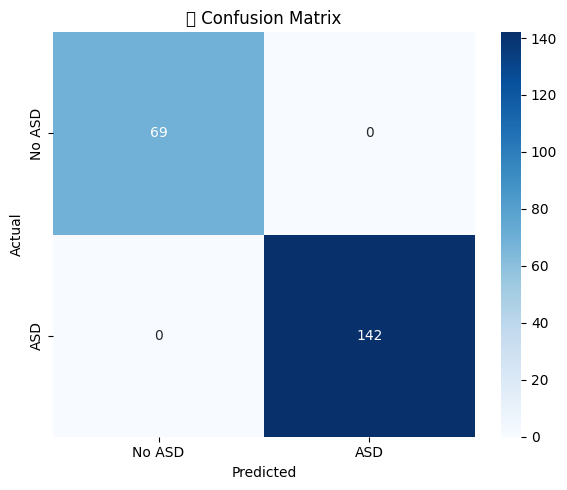

test_set_accuracy: 100.00%


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No ASD", "ASD"], yticklabels=["No ASD", "ASD"])
plt.title("🔍 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Plot bar graph of classification report scores
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0, 1])
labels = ["No ASD", "ASD"]

acc = accuracy_score(all_labels, all_preds)
test_set_accuracy = acc * 100
print("test_set_accuracy: {:.2f}%".format(test_set_accuracy))

<ipython-input-68-a18994b0cc59>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


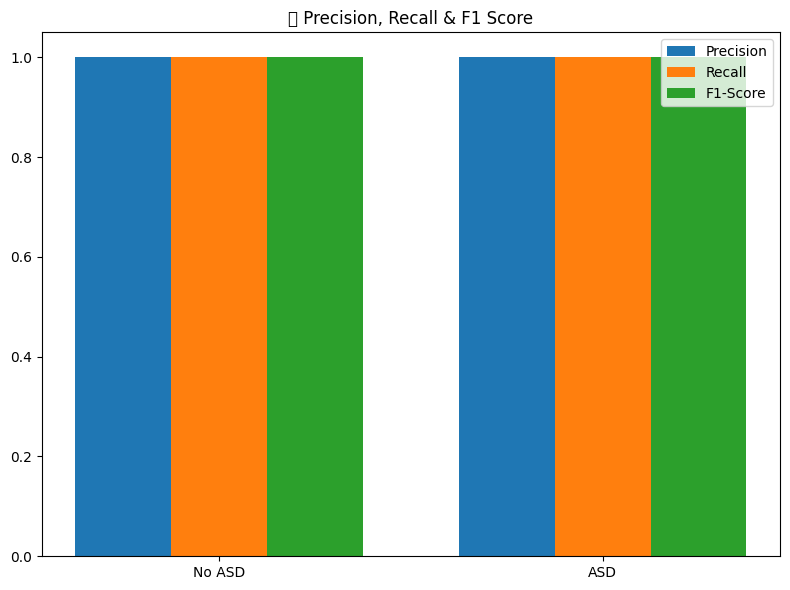

In [68]:
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')
plt.xticks(x, labels)
plt.title("📊 Precision, Recall & F1 Score")
plt.legend()
plt.tight_layout()
plt.show()


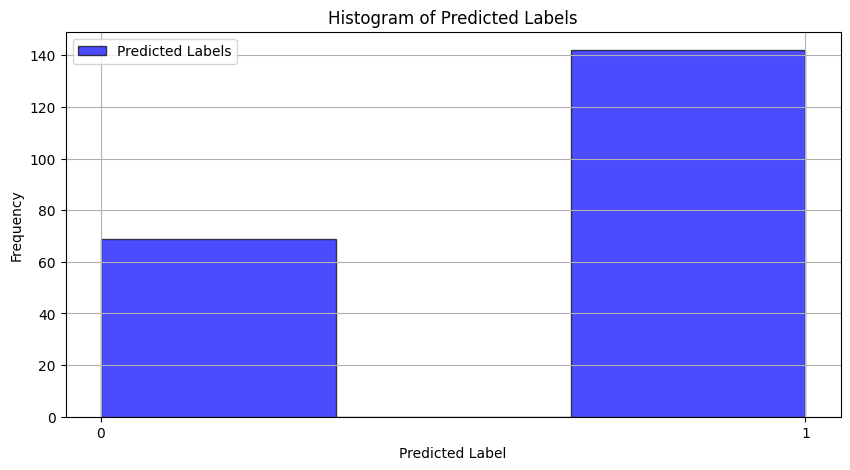

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Generate histogram for the predicted labels
plt.figure(figsize=(10, 5))
plt.hist(all_preds, bins=3, alpha=0.7, color='blue', edgecolor='black', label="Predicted Labels")
plt.title('Histogram of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Frequency')
plt.xticks([0, 1])  # Assuming binary classification (0: No ASD, 1: ASD)
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-84-3465f3169e27>:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


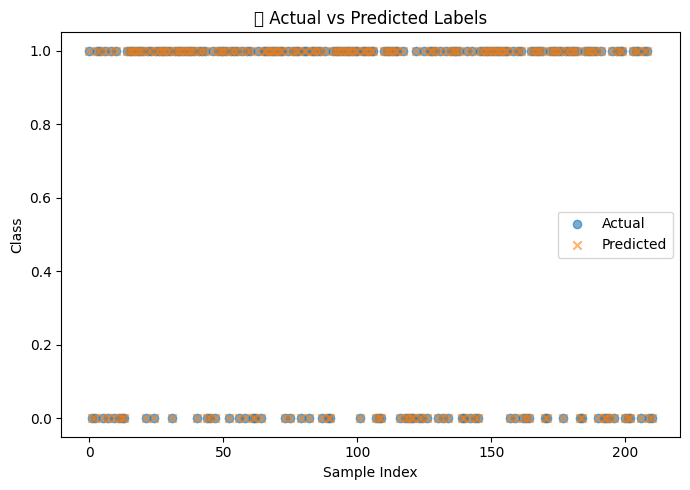

In [84]:

# Scatter plot of actual vs predicted labels

plt.figure(figsize=(7, 5))
plt.scatter(range(len(all_labels)), all_labels, label='Actual', alpha=0.6)
plt.scatter(range(len(all_preds)), all_preds, label='Predicted', alpha=0.6, marker='x')
plt.legend()
plt.title("🎯 Actual vs Predicted Labels")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

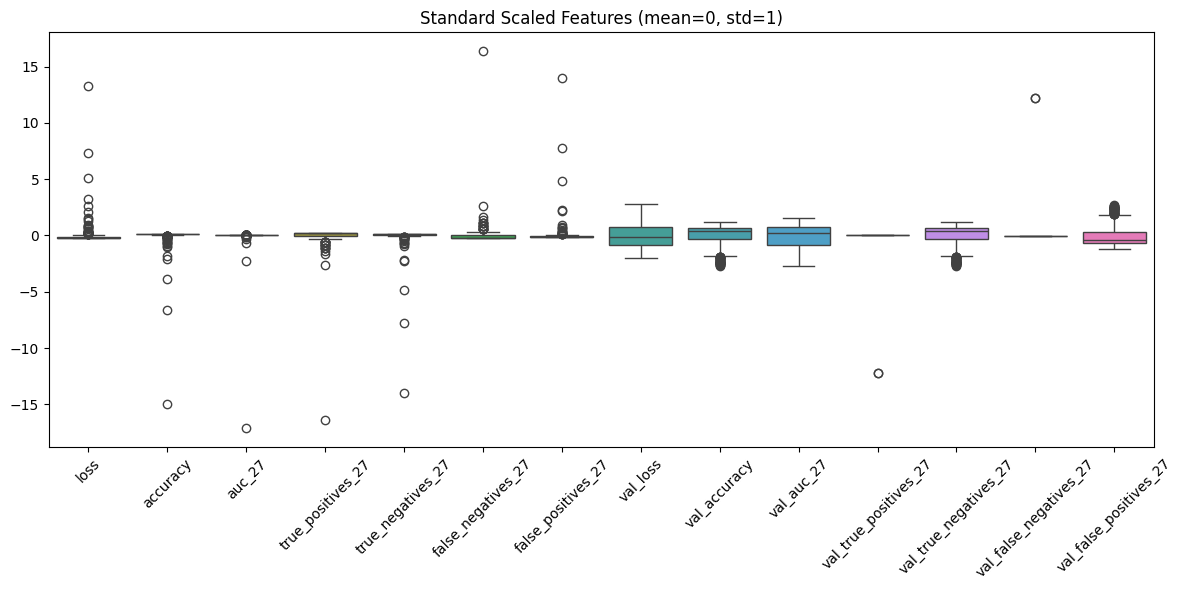

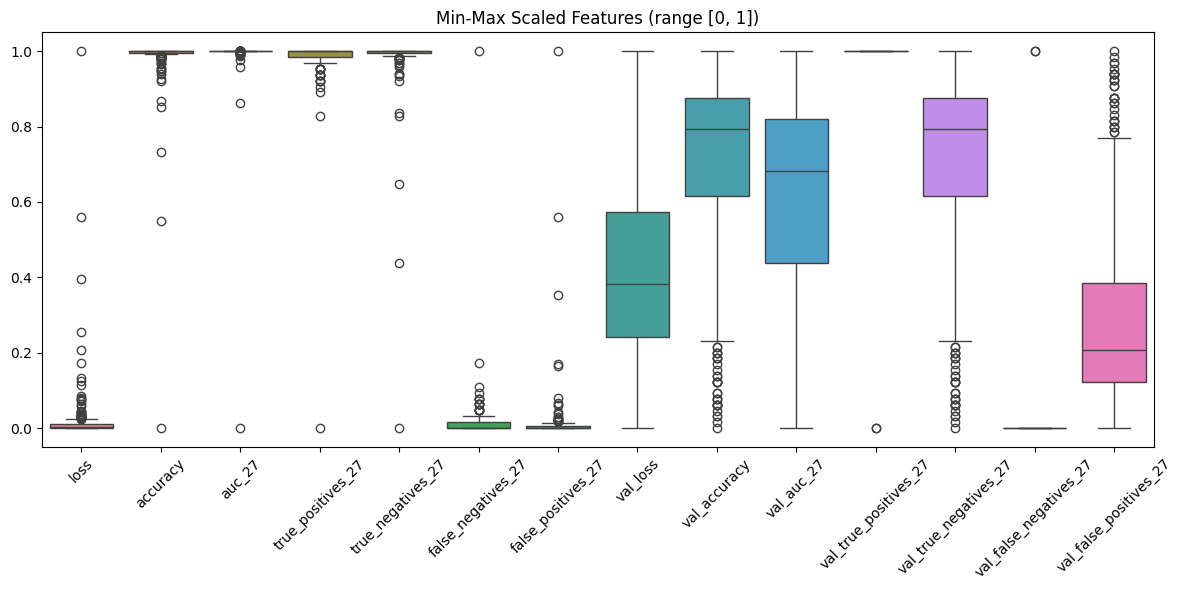

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load your test dataset (raw, unprocessed for this part)
df = pd.read_csv("/content/test3.csv")  # Change path as needed

# Strip column names of leading/trailing spaces
df.columns = df.columns.str.strip()

# Select only the relevant numerical features
features = ['loss','accuracy','auc_27','true_positives_27','true_negatives_27',
            'false_negatives_27','false_positives_27','val_loss','val_accuracy',
            'val_auc_27', 'val_true_positives_27','val_true_negatives_27',
            'val_false_negatives_27','val_false_positives_27']
df_features = df[features].copy()

# Replace 'yes'/'no' (if any) with 1/0
df_features = df_features.apply(lambda col: col.astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0}) if col.dtype == 'object' else col)

# Fill missing values with mode or 0
for col in df_features.columns:
    if df_features[col].isnull().any():
        mode_val = df_features[col].mode()
        df_features[col].fillna(mode_val[0] if not mode_val.empty else 0, inplace=True)

# ---- Plotting Scaled Features ----

# Standard Scaling
scaler_std = StandardScaler()
df_std = pd.DataFrame(scaler_std.fit_transform(df_features), columns=features)

# Min-Max Scaling
scaler_mm = MinMaxScaler()
df_mm = pd.DataFrame(scaler_mm.fit_transform(df_features), columns=features)

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_std)
plt.title("Standard Scaled Features (mean=0, std=1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_mm)
plt.title("Min-Max Scaled Features (range [0, 1])")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-79-57df1a6be682>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


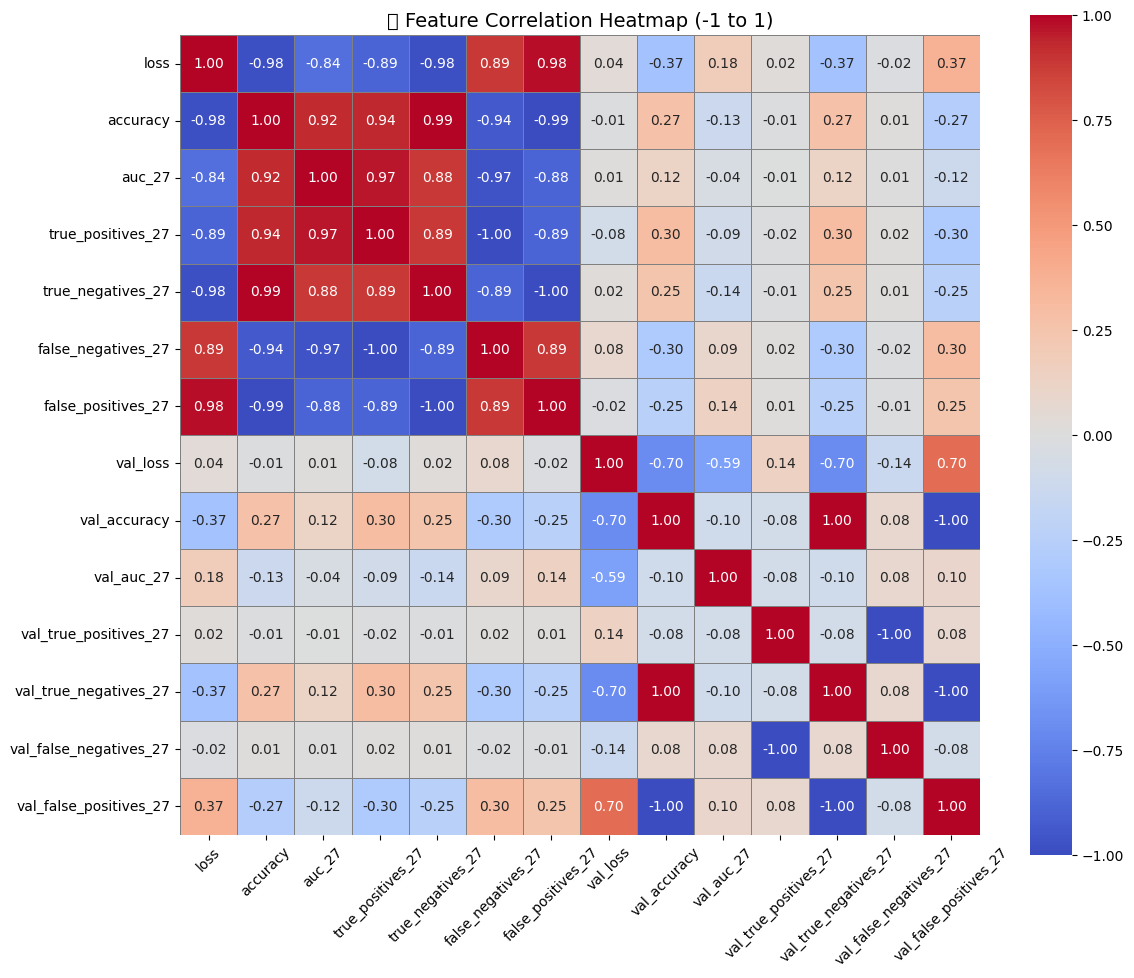

In [79]:
# Correlation Heatmap using Standard Scaled Data
corr_matrix = df_std.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=0.5, linecolor='gray', vmin=-1, vmax=1)

plt.title("📊 Feature Correlation Heatmap (-1 to 1)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [80]:
plt.savefig("filename.png")


<Figure size 640x480 with 0 Axes>